# TP : Réseaux de neurones graphiques.

Dans ce TP, on va appliquer les concepts d'extraction de caractéristiques et de node embedding vus en cours sur un dataset classique [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).



# Représentation graphique avec networkx


In [ ]:
import networkx as nx

## Zachary's karate club network

Zachary's karate club est un graphe décrivant un réseau social de 34 membres d'un club de karaté. Les liens représentent les interactions entre les membres en dehors du club.

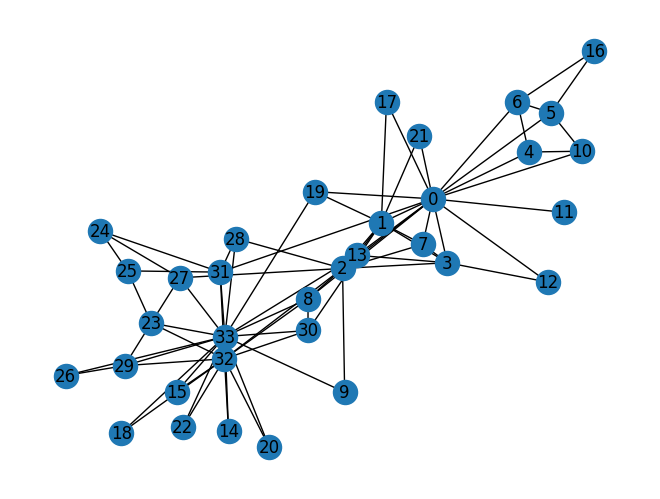

In [ ]:
G = nx.karate_club_graph()

nx.draw(G, with_labels = True)

# Graphe en Tenseur

Nous allons transformer le graphe $G$ en tenseur Pytorch.

In [ ]:
import torch

## Liste des arêtes positives du Karaté club en format `torch.LongTensor`.

In [ ]:
def graph_to_edge_list(G):

  # Cette fonction retourne la liste des arêtes d'un graphe sous forme
  # de couplet composé de deux noeuds.

  edge_list = []

  for edge in G.edges():
    edge_list.append(edge)

  return edge_list

def edge_list_to_tensor(edge_list):

  # Cette fonction transforme un liste d'arêtes en Tenseur Pytorch
  # de dimension [2 x len(edge_list)]

  edge_index = torch.tensor([])


  edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()


  return edge_index

pos_edge_list = graph_to_edge_list(G)
# print(pos_edge_list)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("La dimension de pos_edge_index est : {}".format(pos_edge_index.shape))
print("La somme des valeurs de os_edge_index : {}".format(torch.sum(pos_edge_index)))

La dimension de pos_edge_index est : torch.Size([2, 78])
La somme des valeurs de os_edge_index : 2535


In [ ]:
pos_edge_list

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 17),
 (0, 19),
 (0, 21),
 (0, 31),
 (1, 2),
 (1, 3),
 (1, 7),
 (1, 13),
 (1, 17),
 (1, 19),
 (1, 21),
 (1, 30),
 (2, 3),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 13),
 (2, 27),
 (2, 28),
 (2, 32),
 (3, 7),
 (3, 12),
 (3, 13),
 (4, 6),
 (4, 10),
 (5, 6),
 (5, 10),
 (5, 16),
 (6, 16),
 (8, 30),
 (8, 32),
 (8, 33),
 (9, 33),
 (13, 33),
 (14, 32),
 (14, 33),
 (15, 32),
 (15, 33),
 (18, 32),
 (18, 33),
 (19, 33),
 (20, 32),
 (20, 33),
 (22, 32),
 (22, 33),
 (23, 25),
 (23, 27),
 (23, 29),
 (23, 32),
 (23, 33),
 (24, 25),
 (24, 27),
 (24, 31),
 (25, 31),
 (26, 29),
 (26, 33),
 (27, 33),
 (28, 31),
 (28, 33),
 (29, 32),
 (29, 33),
 (30, 32),
 (30, 33),
 (31, 32),
 (31, 33),
 (32, 33)]



## Liste des arêtes négatives.

In [ ]:
import random

def sample_negative_edges(G, num_neg_samples):
    # Cette fonction retourne la liste des arêtes négatives.
      neg_edge_list = []

      num_nodes = G.number_of_nodes()
      max_num_edge = (num_nodes ** 2 - num_nodes) // 2  # upper triangle size
      num_neg_samples = min(num_neg_samples, max_num_edge - G.number_of_edges())

      neg_edges = []
      idx_to_edge = lambda idx: (idx // num_nodes, idx % num_nodes)
      for i in range(max_num_edge + num_nodes):
        edge = idx_to_edge(i)
        neg_edges += (edge[0] != edge[1] and edge not in G.edges) * [idx_to_edge(i)]

      neg_idxs = sorted(random.sample(range(len(neg_edges)), k=num_neg_samples))
      neg_edge_list = [neg_edges[i] for i in neg_idxs]

      return neg_edge_list

# Echantillon de 78 arêtes négatives
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Convertir la liste des arêtes négatives en tenseur
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("Le tenseur neg_edge_index est de dimension {}".format(neg_edge_index.shape))

# Echantillon de 78 arêtes négatives
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Convertir la liste des arêtes négatives en tenseur
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("Le tenseur neg_edge_index est de dimension {}".format(neg_edge_index.shape))


Le tenseur neg_edge_index est de dimension torch.Size([2, 78])
Le tenseur neg_edge_index est de dimension torch.Size([2, 78])


In [ ]:
len(neg_edge_list)

78

# Node Embeddings

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


On va utiliser ici le module [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) de PyTorch.

In [ ]:
# Initialisation de la couche d'embeddings
# avec, par exemple, 4 objets de dimension 8 chacun

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Embedding layer: {}'.format(emb_sample))

Embedding layer: Embedding(4, 8)


On peut sélectionner l'embedding d'un objet en utilisant l'indice correspondant.

In [ ]:
# Sélectionner un seul embedding
id = torch.LongTensor([1])
print(emb_sample(id))

# Sélectionner plusieurs embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Obtenir la dimension de la mtrice de poids de l'embedding
shape = emb_sample.weight.data.shape
print(shape)

# Affecter de nouvelles valeurs à la matrice de poids (ici des 1)
emb_sample.weight.data = torch.ones(shape)

# Vérifier la nouvelle affectation
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[ 0.0101,  0.8362,  1.2051, -0.0683, -0.4875, -0.4971,  1.4690,  0.0375]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 0.0101,  0.8362,  1.2051, -0.0683, -0.4875, -0.4971,  1.4690,  0.0375],
        [ 0.6357, -0.7775, -0.0557, -0.0443,  2.0859,  0.1051,  0.0199, -0.6802]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


On va appliquer à cela au jeu de données Zachary's karaté club.


*   On veut associer un vecteur de dimension 16 à chaque noeud du graphe.
*   on veut initialiser la matrice avec une distribution uniforme dans $[0, 1]$ en utilisant [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).



In [ ]:
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):

  # Ecrire une fonction qui implémente la matrice d'embeddings pour les noeuds.
  # La fonction doit retourner un embedding de format torch.nn initalisé selon
  # une loi uniforme dans [0,1].

  emb = None

  emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)
  shape = emb.weight.data.shape
  emb.weight.data = torch.rand(shape)

  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

print("Embedding: {}".format(emb))

print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


## Visualisation des embeddings

Nous allons projet les embeddings inialisés ci-dessous en deux dimensions afin de les visualiser.

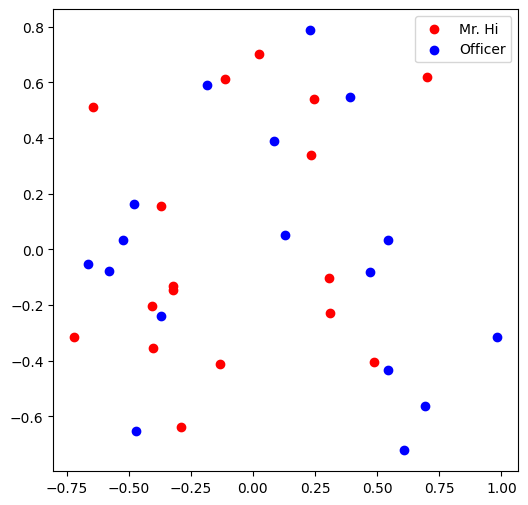

In [ ]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

visualize_emb(emb)

## Calcul des embeddings par descente du gradient.

In [ ]:
def create_loss_function():
    loss_fn = nn.BCELoss()
    sigmoid = nn.Sigmoid()
    return loss_fn, sigmoid

loss_function, sigmoid = create_loss_function()

In [ ]:
from torch.optim import SGD
def accuracy(pred, label):
  accu = 0.0
  accu = torch.sum(torch.round(pred) == label) / pred.shape[0]

  return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):

  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):

    optimizer.zero_grad()

    u, v = train_edge[0], train_edge[1]
    pred = sigmoid(torch.bmm(emb(u).unsqueeze(1), emb(v).unsqueeze(2)).squeeze())
    loss = loss_fn(pred, train_label)

    loss.backward()
    optimizer.step()

    print(
      f"[Epoch {i:4d}]\t"
      f"acc: {accuracy(pred, train_label): .4f}\t"
      f"loss: {loss.item(): .6f}"
    )


pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

train_label = torch.cat([pos_label, neg_label], dim=0)


train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

train(emb, loss_fn, sigmoid, train_label, train_edge)

[Epoch    0]	acc:  0.5000	loss:  2.055300
[Epoch    1]	acc:  0.5000	loss:  2.039753
[Epoch    2]	acc:  0.5000	loss:  2.010489
[Epoch    3]	acc:  0.5000	loss:  1.969383
[Epoch    4]	acc:  0.5000	loss:  1.918306
[Epoch    5]	acc:  0.5000	loss:  1.859078
[Epoch    6]	acc:  0.5000	loss:  1.793455
[Epoch    7]	acc:  0.5000	loss:  1.723093
[Epoch    8]	acc:  0.5000	loss:  1.649539
[Epoch    9]	acc:  0.5000	loss:  1.574213
[Epoch   10]	acc:  0.5000	loss:  1.498402
[Epoch   11]	acc:  0.5000	loss:  1.423243
[Epoch   12]	acc:  0.5000	loss:  1.349719
[Epoch   13]	acc:  0.5000	loss:  1.278658
[Epoch   14]	acc:  0.5000	loss:  1.210721
[Epoch   15]	acc:  0.5000	loss:  1.146415
[Epoch   16]	acc:  0.5000	loss:  1.086091
[Epoch   17]	acc:  0.5064	loss:  1.029964
[Epoch   18]	acc:  0.5064	loss:  0.978116
[Epoch   19]	acc:  0.5064	loss:  0.930525
[Epoch   20]	acc:  0.5128	loss:  0.887080
[Epoch   21]	acc:  0.5128	loss:  0.847603
[Epoch   22]	acc:  0.5256	loss:  0.811863
[Epoch   23]	acc:  0.5641	loss:  0

## Visualisation des embeddings calculés

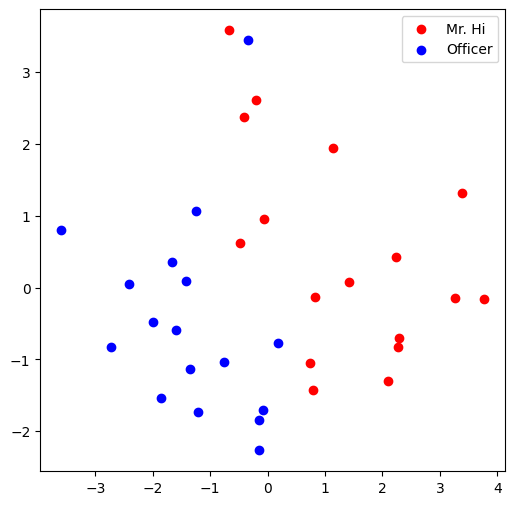

In [ ]:
visualize_emb(emb)